# Interactive Plotting and Monte Carlo simulations of CPPI

In [1]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import numpy as np
import edhec_risk_kit_done as erk

%load_ext autoreload
%autoreload 2

## GBM Interactive Plots

<AxesSubplot:>

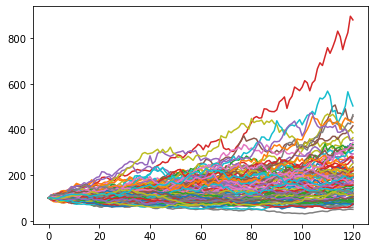

In [2]:
erk.gbm(10,100).plot(legend=False)

<AxesSubplot:>

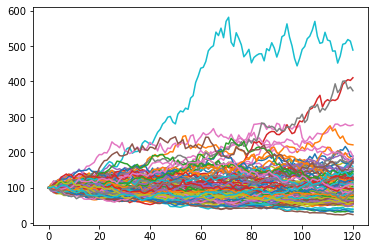

In [3]:
erk.gbm(10,100, mu=0.01).plot(legend=False)

In [15]:
def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion model
    """
    s_0 = 100
    prices = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, s_0=s_0)
    ax = prices.plot(legend=False, color="indianred", alpha=0.5, linewidth=2, figsize=(12,5))
    ax.axhline(y=s_0, ls=":", color="black")
    ax.set_ylim(top=400)
    # draw a dot at the origin
    ax.plot(0, s_0, marker="o", color="darkred", alpha=0.2)

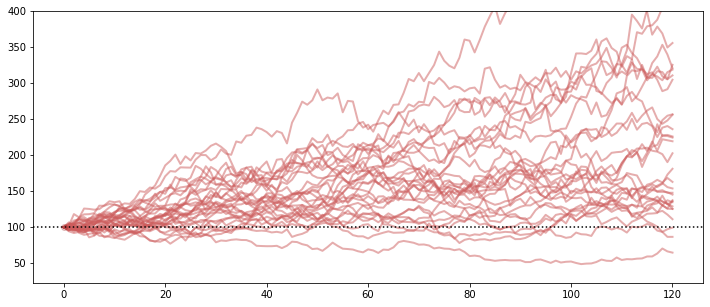

In [16]:
show_gbm(30, 0.07, 0.15)

In [17]:
gbm_controls = widgets.interactive(show_gbm, 
                                   n_scenarios = (1, 20, 1), 
                                   mu = (-0.2, 0.2, 0.01), 
                                   sigma = (0,0.3, 0.01))

In [18]:
display(gbm_controls)

interactive(children=(IntSlider(value=10, description='n_scenarios', max=20, min=1), FloatSlider(value=0.0, de…

## Interactive CPPI Simulation - Monte Carlo

In [23]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0, riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r), riskfree_rate=riskfree_rate, m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    y_max = wealth.values.max()*y_max/100
    ax = wealth.plot(legend=False, alpha=0.3, color="indianred", figsize=(12,6))
    ax.axhline(y=start, ls=":", color="black")
    ax.axhline(y=start*floor, ls="--", color="red")
    ax.set_ylim(top=y_max)
    
cppi_controls = widgets.interactive(show_cppi,
                                    n_scenarios=widgets.IntSlider(min=1, max=1000, steps=5, value=50),
                                    mu=(0., +.2, .01),
                                    sigma=(0, .30, .05),
                                    floor=(0, 2, .1),
                                    m=(1, 5, .5),
                                    riskfree_rate=(0, .05, .01),
                                    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                            description="Zoom Y Axis")
                                   )
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1), FloatSlider(value=0.07,…

In [24]:
def gbm(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0, prices=True):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices through Monte Carlo
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year) + 1
    # the standard way ...
    # rets_plus_1 = np.random.normal(loc=mu*dt+1, scale=sigma*np.sqrt(dt), size=(n_steps, n_scenarios))
    # without discretization error ...
    rets_plus_1 = np.random.normal(loc=(1+mu)**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1
    ret_val = s_0*pd.DataFrame(rets_plus_1).cumprod() if prices else rets_plus_1-1
    return ret_val